In [10]:
import pandas as pd
import numpy as np
rsStationList = pd.read_csv(r'/Users/aaroncao/Documents/California Wildfire Project/California_Fire_Incidents - 3169904 station list.csv')
rsWeatherDf = pd.read_csv(r'/Users/aaroncao/Documents/California Wildfire Project/California_Fire_Incidents - 3169904 weekly summaries with missing data filled.csv')
fireDf = pd.read_csv(r'/Users/aaroncao/Documents/California Wildfire Project/California_Fire_Incidents - California_Fire_Incidents.csv')
#%store finalWeeklyWeatherDf
#%store stationInfoDf
#rsWeatherDf = finalWeeklyWeatherDf.copy()
#rsStationList = stationInfoDf.copy()
rsFireDf = fireDf[fireDf['Counties'] == 'Riverside']
print(rsWeatherDf.head())

       STATION                  NAME  LATITUDE  LONGITUDE  ELEVATION  \
0  USC00045091  LONG VALLEY 2, CA US  33.81299 -116.64193     2554.2   
1  USC00045091  LONG VALLEY 2, CA US  33.81299 -116.64193     2554.2   
2  USC00045091  LONG VALLEY 2, CA US  33.81299 -116.64193     2554.2   
3  USC00045091  LONG VALLEY 2, CA US  33.81299 -116.64193     2554.2   
4  USC00045091  LONG VALLEY 2, CA US  33.81299 -116.64193     2554.2   

  DATE - first day of week to last day  AWND - avg wind speed mph  \
0              2017-01-01 : 2017-01-07                   5.363065   
1              2017-01-08 : 2017-01-14                   5.363065   
2              2017-01-15 : 2017-01-21                   5.363065   
3              2017-01-22 : 2017-01-28                   5.363065   
4              2017-01-29 : 2017-02-04                   5.309970   

   avg precipitation in  total precipitation recorded in  avg snowfall in  \
0              0.071429                             0.50         0.540722  

In [11]:
rsFireDf = rsFireDf[['Counties','Started','Extinguished','Latitude','Longitude','MajorIncident','AcresBurned']]
rsFireDf['Started'] = rsFireDf['Started'].str[:10]
rsFireDf['Extinguished'] = rsFireDf['Extinguished'].str[:10]
print(rsFireDf.head())

     Counties     Started Extinguished   Latitude   Longitude  MajorIncident  \
2   Riverside  2013-07-15   2013-07-30  33.709500 -116.728850          False   
6   Riverside  2013-08-07   2013-08-12  33.861570 -116.904270           True   
16  Riverside  2013-05-01   2013-05-04  34.288877 -116.941311           True   
24  Riverside  2013-08-05   2013-08-09  33.622360 -117.402880          False   
35  Riverside  2013-05-04   2013-05-05  33.894055 -116.855019          False   

    AcresBurned  
2       27531.0  
6       20292.0  
16       3166.0  
24       1383.0  
35        510.0  


In [12]:
from math import sin, cos, sqrt, atan2, radians
def isWithinRadius(radius, lat1, lon1, lat2, lon2): #KILOMETERS
    # Approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    if (distance<=radius):
        return True
    return False
def distBetweenCoord(lat1, lon1, lat2, lon2): #KILOMETERS
    # Approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance

In [13]:
rsCombinedDf = rsWeatherDf[['STATION','DATE - first day of week to last day','AWND - avg wind speed mph','avg precipitation in','total precipitation recorded in','avg snowfall in','total snowfall in','TAVG - avg temp F','avg max temp F','abs max temp F','avg min temp F','abs min temp F','avg temp between min and max (using columns M and O)', 'LATITUDE', 'LONGITUDE', 'ELEVATION']]
rsCombinedDf.rename(columns={'DATE - first day of week to last day':'DATE','AWND - avg wind speed mph':'AWND','avg precipitation in':'AVG PRECIP','total precipitation recorded in':'TOTAL PRECIP','avg snowfall in':'AVG SNOW','total snowfall in':'TOTAL SNOW','TAVG - avg temp F':'AVG TEMP','avg max temp F':'AVG MAX TEMP','abs max temp F':'MAX TEMP','avg min temp F':'AVG MIN TEMP','abs min temp F':'MIN TEMP','avg temp between min and max (using columns M and O)':'TAVG2'}, inplace=True)
rsCombinedDf['Begin'] = rsCombinedDf['DATE'].str.slice(0,10)
rsCombinedDf['End'] = rsCombinedDf['DATE'].str.slice(13,23)
rsCombinedDf = rsCombinedDf.drop(columns=['DATE'])
#print(rsCombinedDf.head())
print(rsCombinedDf.columns)

Index(['STATION', 'AWND', 'AVG PRECIP', 'TOTAL PRECIP', 'AVG SNOW',
       'TOTAL SNOW', 'AVG TEMP', 'AVG MAX TEMP', 'MAX TEMP', 'AVG MIN TEMP',
       'MIN TEMP', 'TAVG2', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'Begin',
       'End'],
      dtype='object')


/var/folders/3r/whhpn5fn6bx9pr68gv_sb7p80000gn/T/ipykernel_63298/264618170.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rsCombinedDf.rename(columns={'DATE - first day of week to last day':'DATE','AWND - avg wind speed mph':'AWND','avg precipitation in':'AVG PRECIP','total precipitation recorded in':'TOTAL PRECIP','avg snowfall in':'AVG SNOW','total snowfall in':'TOTAL SNOW','TAVG - avg temp F':'AVG TEMP','avg max temp F':'AVG MAX TEMP','abs max temp F':'MAX TEMP','avg min temp F':'AVG MIN TEMP','abs min temp F':'MIN TEMP','avg temp between min and max (using columns M and O)':'TAVG2'}, inplace=True)


In [14]:
rsStationList = rsStationList[['STATION', 'LATITUDE', 'LONGITUDE']]
print(rsStationList)

        STATION  LATITUDE  LONGITUDE
0   USC00045091  33.81299 -116.64193
1   USC00047470  33.95110 -117.38800
2   USR0000CLHO  34.01780 -116.18780
3   USC00042410  33.73770 -115.39250
4   USR0000CRIC  34.06080 -114.73220
5   USW00003104  33.63166 -116.16412
6   USC00040924  33.61389 -114.59789
7   USC00041738  33.66170 -115.72060
8   USR0000CSRO  33.52860 -117.23060
9   USR0000CANZ  33.55500 -116.67300
10  USW00053151  33.43920 -117.19040
11  USW00093138  33.82216 -116.50433
12  USR0000CCRT  33.74030 -116.84140
13  USC00044259  33.70860 -116.21520
14  USC00042598  33.80807 -115.45138
15  USR0000CKEE  33.66670 -116.76670
16  USC00045502  33.56970 -116.07300
17  USC00046635  33.82750 -116.50970
18  USW00003171  33.95282 -117.43523
19  USC00044211  33.75720 -116.70660
20  USR0000CELC  33.64720 -117.41110
21  USC00042805  33.68600 -117.34580
22  USR0000CBEU  33.93060 -116.95000
23  USW00023158  33.61876 -114.71451
24  USC00043896  33.73810 -116.89390
25  USC00047813  33.79650 -116.97530
2

In [15]:
def findClosestStationOLD(lat1, lon1): #is faster but not as cool as numpy
    stationInfoArr = rsStationList.to_numpy()
    num_rows = np.shape(stationInfoArr)[0]
    distArr = [[None for x in range(2)] for y in range(num_rows)] # 2 is width(items per list), num_rows is height(number of lists)
    #distArr = np.empty([num_rows, 2], dtype=object) # goes by np.empty(number of lists, items per list), backwards of previous line
    for i in range(num_rows):
        distArr[i][0] = stationInfoArr[i][0] #FIX: empty numpy array is filled with floats so cannot replace with string right away?
        lat2 = stationInfoArr[i][1]
        lon2 = stationInfoArr[i][2]
        dist = distBetweenCoord(lat1, lon1, lat2, lon2)
        distArr[i][1] = dist
    closestStation = ''
    closestDistance = 50000 #km
    for i in range(num_rows):
        currStation = distArr[i][0]
        currDistance = distArr[i][1]
        if currDistance<closestDistance:
            closestStation = currStation
            closestDistance = currDistance
    #indexOfSmallestStation = np.argmin(distArr[:,1]) # [:,1] slices to only take the second column
    #closestStation = distArr[indexOfSmallestStation][0]
    return closestStation

def findClosestStation(lat1, lon1):
    stationInfoArr = rsStationList.to_numpy()
    num_rows = np.shape(stationInfoArr)[0]
    #distArr = [[None for x in range(2)] for y in range(num_rows)] # 2 is width(items per list), num_rows is height(number of lists)
    distArr = np.empty([num_rows, 2], dtype=object) # goes by np.empty(number of lists, items per list), backwards of previous line
    for i in range(num_rows):
        distArr[i][0] = stationInfoArr[i][0] #FIX: empty numpy array is filled with floats so cannot replace with string right away?
        lat2 = stationInfoArr[i][1]
        lon2 = stationInfoArr[i][2]
        dist = distBetweenCoord(lat1, lon1, lat2, lon2)
        distArr[i][1] = dist
    #closestStation = ''
    #closestDistance = 50000 #km
    #for i in range(num_rows):
    #    currStation = distArr[i][0]
    #    currDistance = distArr[i][1]
    #    if currDistance<closestDistance:
    #        closestStation = currStation
    #        closestDistance = currDistance
    indexOfSmallestStation = np.argmin(distArr[:,1]) # [:,1] slices to only take the second column
    closestStation = distArr[indexOfSmallestStation][0]
    return closestStation

def findAllStationsInRange(radius, lat1, lon1):
    stationInfoArr = rsStationList.to_numpy()
    num_rows = np.shape(stationInfoArr)[0]
    #distArr = [[None for x in range(2)] for y in range(num_rows)] # 2 is width(items per list), num_rows is height(number of lists)
    distArr = np.empty([num_rows, 2], dtype=object) # goes by np.empty(number of lists, items per list), backwards of previous line
    for i in range(num_rows):
        distArr[i][0] = stationInfoArr[i][0]
        lat2 = stationInfoArr[i][1]
        lon2 = stationInfoArr[i][2]
        dist = distBetweenCoord(lat1, lon1, lat2, lon2)
        distArr[i][1] = dist
    
    returnArr = []

    for i in range(num_rows):
        currStation = distArr[i][0]
        currDistance = distArr[i][1]
        if currDistance<radius:
            returnArr.append(currStation)

    #TEST IF THIS NEXT SECTION HELPS

    if not returnArr:  #check if no station within range then get closest station
    #    indexOfSmallestStation = np.argmin(distArr[:,1]) # [:,1] slices to only take the second column
    #    returnArr.append(distArr[indexOfSmallestStation][0])
        returnArr.append('no station within 40km')
    

    return returnArr


In [16]:
#rsCombinedDf['fire'] = "None"
rsCombinedDf['fire'] = 'None'
print(rsCombinedDf.head())

       STATION      AWND  AVG PRECIP  TOTAL PRECIP   AVG SNOW  TOTAL SNOW  \
0  USC00045091  5.363065    0.071429          0.50   0.540722    3.785052   
1  USC00045091  5.363065    0.240000          1.20   8.000000   16.000000   
2  USC00045091  5.363065    0.497143          3.48  13.200000   39.600000   
3  USC00045091  5.363065    0.741429          5.19  11.000000   33.000000   
4  USC00045091  5.309970    0.077143          0.54   0.800000    4.000000   

    AVG TEMP  AVG MAX TEMP  MAX TEMP  AVG MIN TEMP  MIN TEMP      TAVG2  \
0  47.376344     41.714286      50.0     27.142857      16.0  34.428571   
1  47.376344     42.857143      53.0     31.285714      22.0  37.071429   
2  47.376344     35.333333      46.0     11.166667       5.0  23.250000   
3  47.376344     34.857143      40.0      9.285714      -2.0  22.071429   
4  49.581029     53.142857      56.0     24.428571      18.0  38.785714   

   LATITUDE  LONGITUDE  ELEVATION       Begin         End  fire  
0  33.81299 -116.641

In [17]:
print(rsFireDf.head())

     Counties     Started Extinguished   Latitude   Longitude  MajorIncident  \
2   Riverside  2013-07-15   2013-07-30  33.709500 -116.728850          False   
6   Riverside  2013-08-07   2013-08-12  33.861570 -116.904270           True   
16  Riverside  2013-05-01   2013-05-04  34.288877 -116.941311           True   
24  Riverside  2013-08-05   2013-08-09  33.622360 -117.402880          False   
35  Riverside  2013-05-04   2013-05-05  33.894055 -116.855019          False   

    AcresBurned  
2       27531.0  
6       20292.0  
16       3166.0  
24       1383.0  
35        510.0  


In [31]:
import datetime as dt
def isDuringWeek(beginDate, endDate, findDate): #year-month-day
    d1 = dt.datetime(int(beginDate[0:4]),int(beginDate[5:7]), int(beginDate[8:10]))
    d2 = dt.datetime(int(findDate[0:4]), int(findDate[5:7]), int(findDate[8:10]))
    d3 = dt.datetime(int(endDate[0:4]), int(endDate[5:7]), int(endDate[8:10]))
    return (d1<=d2<=d3)

#only care about fires starting for this one
def combineWithClosestStation(givenDftoCombine): #pass rsCombinedDf as param for givenDFtoCombine
    #matching

    combinedDf = givenDftoCombine.copy()

    for ind in rsFireDf.index:
        lat1 = rsFireDf.at[ind, 'Latitude']
        lon1 = rsFireDf.at[ind, 'Longitude']
        rsFireDf.at[ind,'ClosestStation'] = findClosestStation(lat1, lon1)


    combinedDf_grouped = combinedDf.groupby('STATION')
    for ind in rsFireDf.index:
        currStation = str(rsFireDf.at[ind, 'ClosestStation'])
        fireStartDate = rsFireDf.at[ind, 'Started']
        #currEndDate = rsFireDf.at[ind, 'Extinguished']
        for row_index, row in combinedDf_grouped.get_group(currStation).iterrows():
            if isDuringWeek(row['Begin'], row['End'], fireStartDate):
                fireSize = 'minor'
                if rsFireDf.at[ind, 'MajorIncident']:
                    fireSize = 'major'
                if combinedDf.at[row_index, 'fire']!='major':
                        combinedDf.at[row_index, 'fire'] = fireSize
                    
                break
    
    return combinedDf

def combineWithStationsInRange(givenDftoCombine, radius): #pass rsCombinedDf as param for givenDFtoCombine
    #matching
    
    combinedDf = givenDftoCombine.copy()
    combinedDf['fire arr'] = [[] for q in range(len(combinedDf))]
    combinedDf['acres burned'] = 0
    
    #extra
    c1 = 0
    c2 = 0

    for ind in rsFireDf.index:
        lat1 = rsFireDf.at[ind, 'Latitude']
        lon1 = rsFireDf.at[ind, 'Longitude']
        stationsInRange = findAllStationsInRange(radius, lat1, lon1)

        #extra
        if (stationsInRange[-1] == 'no station within 40km'):
            c1+=1
            stationsInRange.pop()
        
        rsFireDf.at[ind,'ClosestStation'] = stationsInRange

    combinedDf_grouped = combinedDf.groupby('STATION')
    for ind in rsFireDf.index: #loop through each fire
        
        fireStartDate = rsFireDf.at[ind, 'Started']
        #currEndDate = rsFireDf.at[ind, 'Extinguished']

        for i in range(len(rsFireDf.at[ind, 'ClosestStation'])): #change for each station
            currStation = str(rsFireDf.at[ind, 'ClosestStation'][i])

            for row_index, row in combinedDf_grouped.get_group(currStation).iterrows(): #find specific week to change
                if isDuringWeek(row['Begin'], row['End'], fireStartDate):
                    fireSize = 'minor'
                    if rsFireDf.at[ind, 'MajorIncident']:
                        fireSize = 'major'

                    if combinedDf.at[row_index, 'fire']!='major':
                        combinedDf.at[row_index, 'fire'] = fireSize
                    
                    combinedDf.at[row_index, 'fire arr'].append(fireSize)
                    combinedDf.at[row_index, 'acres burned']=combinedDf.at[row_index, 'acres burned']+rsFireDf.at[ind, 'AcresBurned']
                    #print(combinedDf.at[row_index, 'acres burned'])
                    
                    if len(combinedDf.at[row_index, 'fire arr'])>=2:    
                        c2+=1
                    
                    break
    #extra
    print('num of fires without station:', c1)
    print('num of instances with 2+ fires in the week:', c2)
    return combinedDf


In [32]:

combinedClosestDf = combineWithClosestStation(rsCombinedDf)
print("only closest station:")
print(combinedClosestDf['fire'].value_counts())


only closest station:
None     8819
minor     107
major      17
Name: fire, dtype: int64


In [33]:

combinedInRangeDf = combineWithStationsInRange(rsCombinedDf, 40)
print("stations within 40 km:")
print(combinedInRangeDf['fire'].value_counts())
print(combinedInRangeDf['fire arr'].value_counts())

#18 fires out of range of stations
#include closest station when none within radius! None:8258. minor:627. major:58.
#only ones within radius! None:8272. minor:612. major:59. WHY DOES MAJOR INCREASE???

num of fires without station: 18
num of instances with 2+ fires in the week: 240
stations within 40 km:
None     8272
minor     583
major      88
Name: fire, dtype: int64
[]                                                   8272
[minor]                                               454
[minor, minor]                                         82
[major]                                                55
[minor, minor, minor]                                  34
[major, minor]                                         22
[minor, minor, minor, minor]                            9
[major, major, minor]                                   3
[major, minor, minor]                                   3
[major, minor, major]                                   3
[minor, minor, minor, minor, minor]                     2
[minor, minor, minor, minor, minor, minor, minor]       1
[minor, major]                                          1
[minor, minor, minor, minor, minor, minor]              1
[major, minor, ma

In [21]:

for col in combinedClosestDf.columns:
    print(col)

STATION
AWND
AVG PRECIP
TOTAL PRECIP
AVG SNOW
TOTAL SNOW
AVG TEMP
AVG MAX TEMP
MAX TEMP
AVG MIN TEMP
MIN TEMP
TAVG2
LATITUDE
LONGITUDE
ELEVATION
Begin
End
fire


In [39]:
print(combinedInRangeDf.dtypes)

STATION          object
AWND            float64
AVG PRECIP      float64
TOTAL PRECIP    float64
AVG SNOW        float64
TOTAL SNOW      float64
AVG TEMP        float64
AVG MAX TEMP    float64
MAX TEMP        float64
AVG MIN TEMP    float64
MIN TEMP        float64
TAVG2           float64
LATITUDE        float64
LONGITUDE       float64
ELEVATION       float64
Begin            object
End              object
fire             object
fire arr         object
acres burned    float64
dtype: object


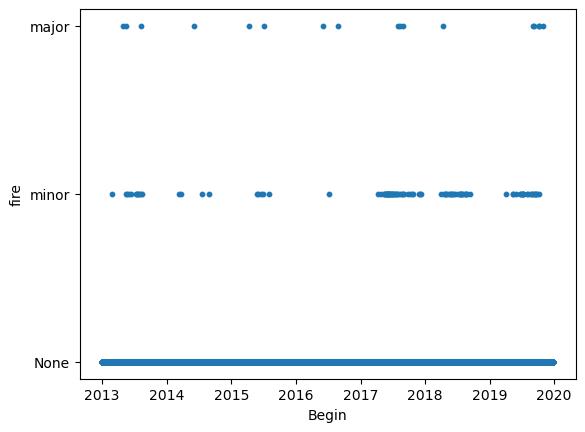

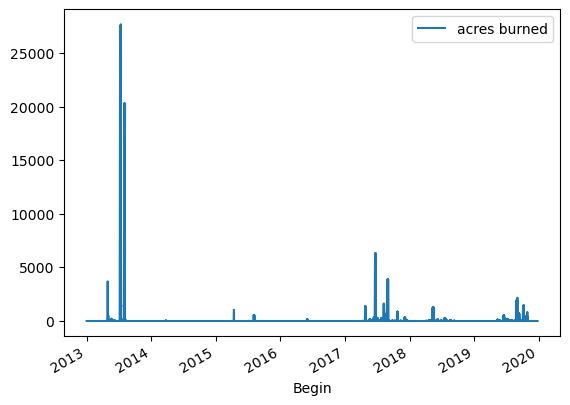

In [41]:
import matplotlib.pyplot as plt

#plotting closest df
closestPlotDf = combinedClosestDf.copy()
closestPlotDf['Begin'] = pd.to_datetime(closestPlotDf['Begin'], format='%Y-%m-%d') #convert to datetime obj
closestPlotDf = closestPlotDf[['STATION', 'Begin', 'fire', 'AVG TEMP', 'AVG MAX TEMP', 'AVG MIN TEMP']]

closestPlotDf['Month'] = pd.DatetimeIndex(closestPlotDf['Begin']).month
closestPlotDf['Year'] = pd.DatetimeIndex(closestPlotDf['Begin']).year

#for plotting the range df
rangePlotDf = combinedInRangeDf.copy()
rangePlotDf['Begin'] = pd.to_datetime(rangePlotDf['Begin'], format='%Y-%m-%d') #convert to datetime obj
rangePlotDf = rangePlotDf[['STATION', 'Begin', 'fire', 'AVG TEMP', 'acres burned']]

rangePlotDf['Month'] = pd.DatetimeIndex(rangePlotDf['Begin']).month
rangePlotDf['Year'] = pd.DatetimeIndex(rangePlotDf['Begin']).year


closestPlotDf = closestPlotDf.set_index('Begin').sort_index().reset_index()
closestPlotDf.plot.scatter(x='Begin', y='fire', s=10)
plt.show()

rangePlotDf = rangePlotDf.set_index('Begin').sort_index().reset_index()
rangePlotDf.plot(x='Begin', y='acres burned')
plt.show()
#SCATTERPLOT will be same for both  range and closest

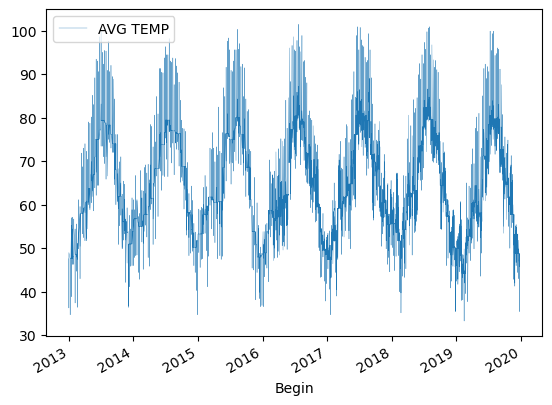

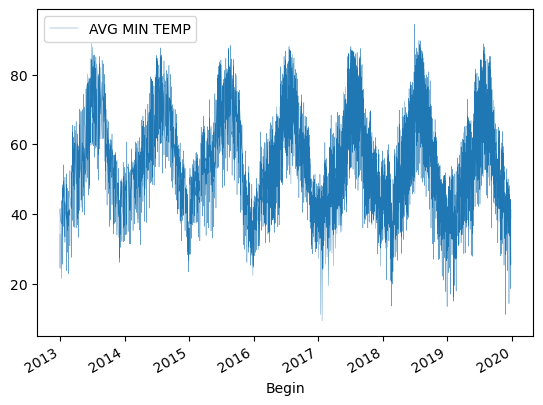

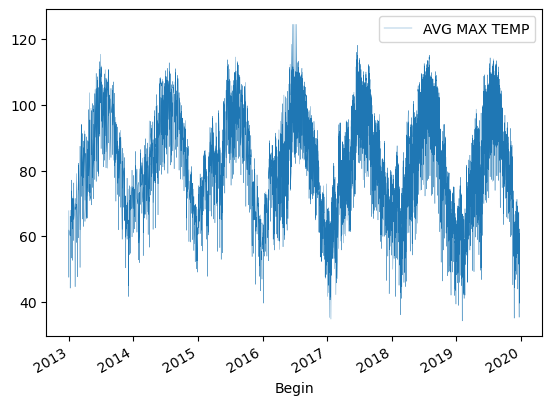

In [24]:
closestPlotDf.plot(x='Begin', y='AVG TEMP', linewidth = 0.25)
plt.show()
closestPlotDf.plot(x='Begin', y='AVG MIN TEMP', linewidth = 0.25)
plt.show()
closestPlotDf.plot(x='Begin', y='AVG MAX TEMP', linewidth = 0.25)
plt.show()


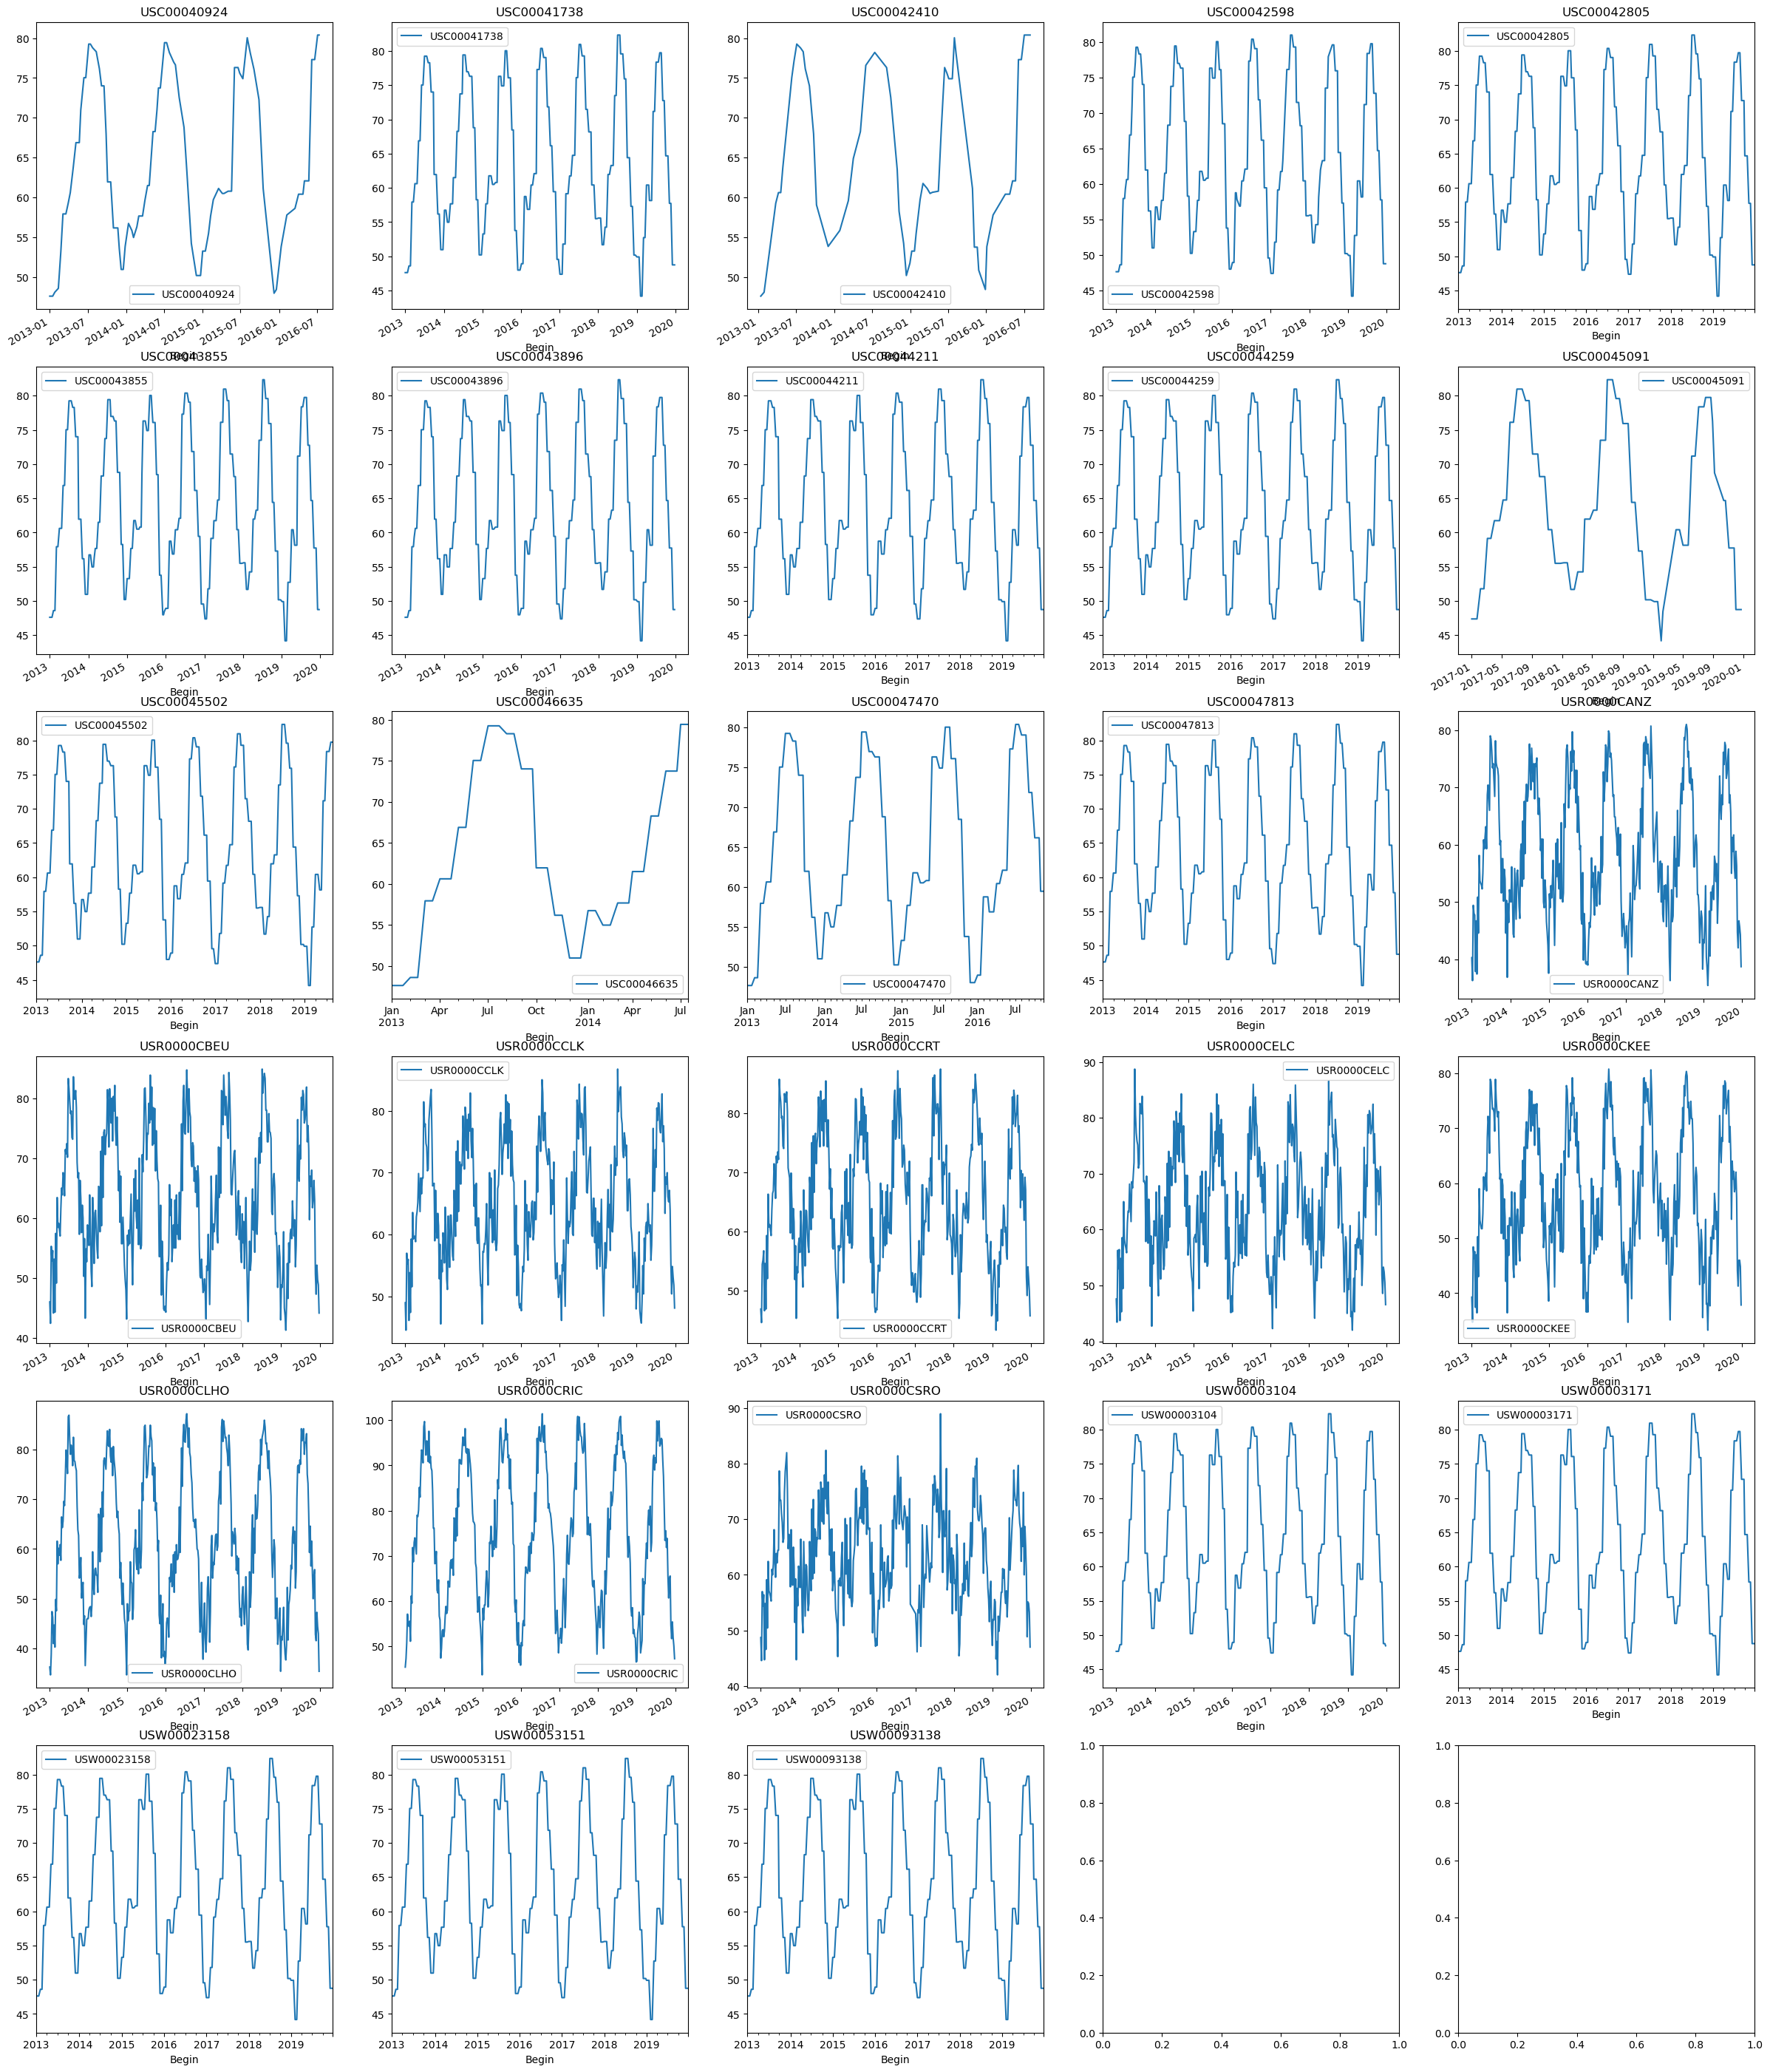

In [25]:
#closestPlotDf.groupby('STATION').plot.scatter(x='AVG MAX TEMP', y='AVG TEMP')
groupedClosestPlotDf = closestPlotDf.groupby('STATION')
# create a grid of subplots with 1 row and 2 columns
fig, axs = plt.subplots(nrows=6, ncols=5, figsize=(30, 40))

# iterate over each group and plot on a separate subplot
for i, (name, group) in enumerate(groupedClosestPlotDf):
    row, col = divmod(i,5)
    ax = axs[row][col]  # select the (row, col) subplot
    group.plot(x='Begin', y='AVG TEMP', label=name, ax=ax)  # plot the group
    ax.set_title(name)  # set the subplot title
    ax.legend()

plt.show()

#USC00042410 has a problem

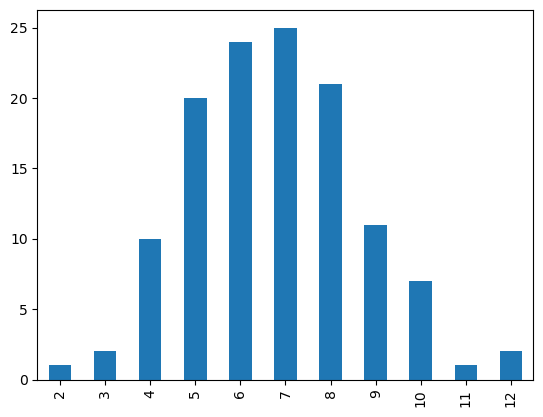

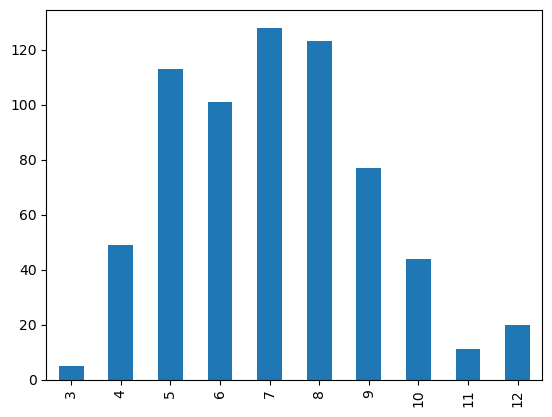

In [26]:
closestMonthBarGraph = closestPlotDf.copy()
closestMonthBarGraph = closestMonthBarGraph[closestMonthBarGraph.fire != 'None']
closestMonthBarGraph['Month'].value_counts().sort_index().plot(kind='bar')
plt.show()


rangeMonthBarGraph = rangePlotDf.copy()
rangeMonthBarGraph = rangeMonthBarGraph[rangeMonthBarGraph.fire != 'None']
rangeMonthBarGraph['Month'].value_counts().sort_index().plot(kind='bar')
plt.show()

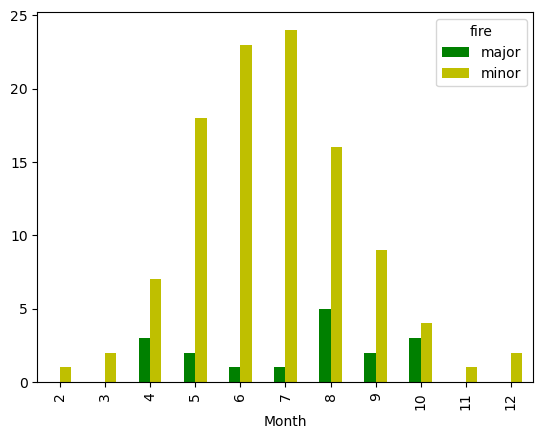

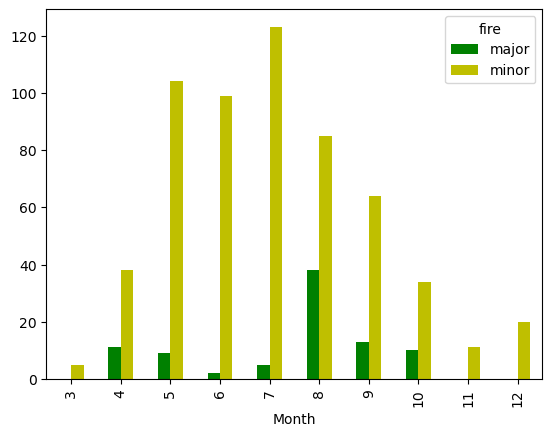

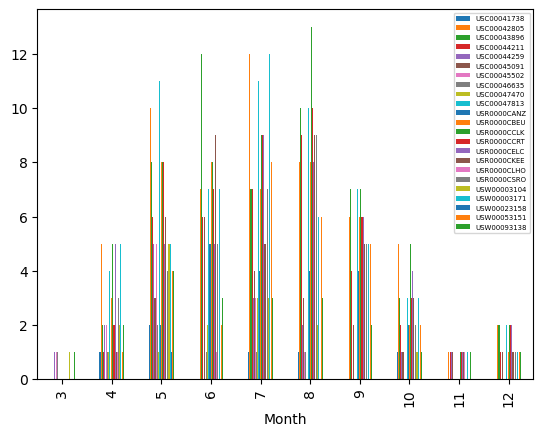

In [27]:
closestMonthBarGraph.groupby('fire').Month.value_counts().unstack(0).plot(kind='bar', color=['g','y'])
plt.show()

rangeMonthBarGraph.groupby('fire').Month.value_counts().unstack(0).plot(kind='bar', color=['g','y'])
plt.show()

rangeMonthBarGraph.groupby('STATION').Month.value_counts().unstack(0).plot(kind='bar')
plt.legend(loc='upper right', fontsize = '5')
plt.show()


In [28]:
#combinedInRangeDf.to_csv(r'/Users/aaroncao/Documents/California Wildfire Project/combinedInRangeDf.csv')

# Assuming you have a DataFrame called 'df' that you want to export
%store combinedInRangeDf

Stored 'combinedInRangeDf' (DataFrame)
